### Importing Dependencies


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import sklearn
import os, pathlib
import kaggle, kagglehub


### Downloading the competition


In [54]:
competition_name = (
    "playground-series-s5e1"  # Change this to the competition you want to download
)
competition_path = pathlib.Path(
    kagglehub.competition.competition_download(competition_name)
)  # Downloads the competition
competition_files: list = os.listdir(
    competition_path
)  # List of the files included in the competition

print(competition_files)

['sample_submission.csv', 'test.csv', 'train.csv']


In [55]:
pl.Config.set_tbl_rows(40)  # polars config set number of rows to display

train_df = pl.read_csv(competition_path / "train.csv")
test_df = pl.read_csv(competition_path / "test.csv")
sample_submission_df = pl.read_csv(competition_path / "sample_submission.csv")

test_df = test_df.with_columns(pl.lit(None).alias("num_sold"))

train_last_row_idx = train_df.height - 1
train_df[train_last_row_idx]


id,date,country,store,product,num_sold
i64,str,str,str,str,f64
230129,"""2016-12-31""","""Singapore""","""Premium Sticker Mart""","""Kerneler Dark Mode""",1622.0


In [56]:
df = pl.concat([train_df, test_df]).with_columns(
    [
        pl.col("id").cast(pl.UInt32),
        pl.col("date").cast(pl.Date),
        pl.col("country").cast(pl.Categorical),
        pl.col("store").cast(pl.Categorical),
        pl.col("product").cast(pl.Categorical),
        pl.col("num_sold").cast(pl.UInt16),
    ]
)



In [57]:
df = pl.concat(
    [df,
     df['country'].to_dummies(),
     df['store'].to_dummies(),
     df['product'].to_dummies()],
    how='horizontal')
df = df.with_columns([
    ((pl.col('date').dt.year() - 2009) / 10).alias('year'),
    (np.sin(2 * np.pi * pl.col("date").dt.month() / 12)).alias("month_sin"),
    (np.sin(2 * np.pi * pl.col("date").dt.day() / 31)).alias("day_sin"),
    (np.sin(2 * np.pi * pl.col("date").dt.weekday() / 7)).alias("weekday_sin"),
    (np.sin(2 * np.pi * pl.col("date").dt.ordinal_day() / 366)).alias("ordinal_day_sin"),
    (np.sin(2 * np.pi * pl.col("date").dt.week() / 53)).alias("week_sin")
])


In [58]:
max_num_sold: int = df['num_sold'].max()  # Using Max value of `num_sold` for scaling
print(max_num_sold)
df = df.with_columns([
    (pl.col('num_sold') / max_num_sold).alias('num_sold_scaled')
])
df = df.drop(['date', 'country', 'store', 'product', 'num_sold'])


5939


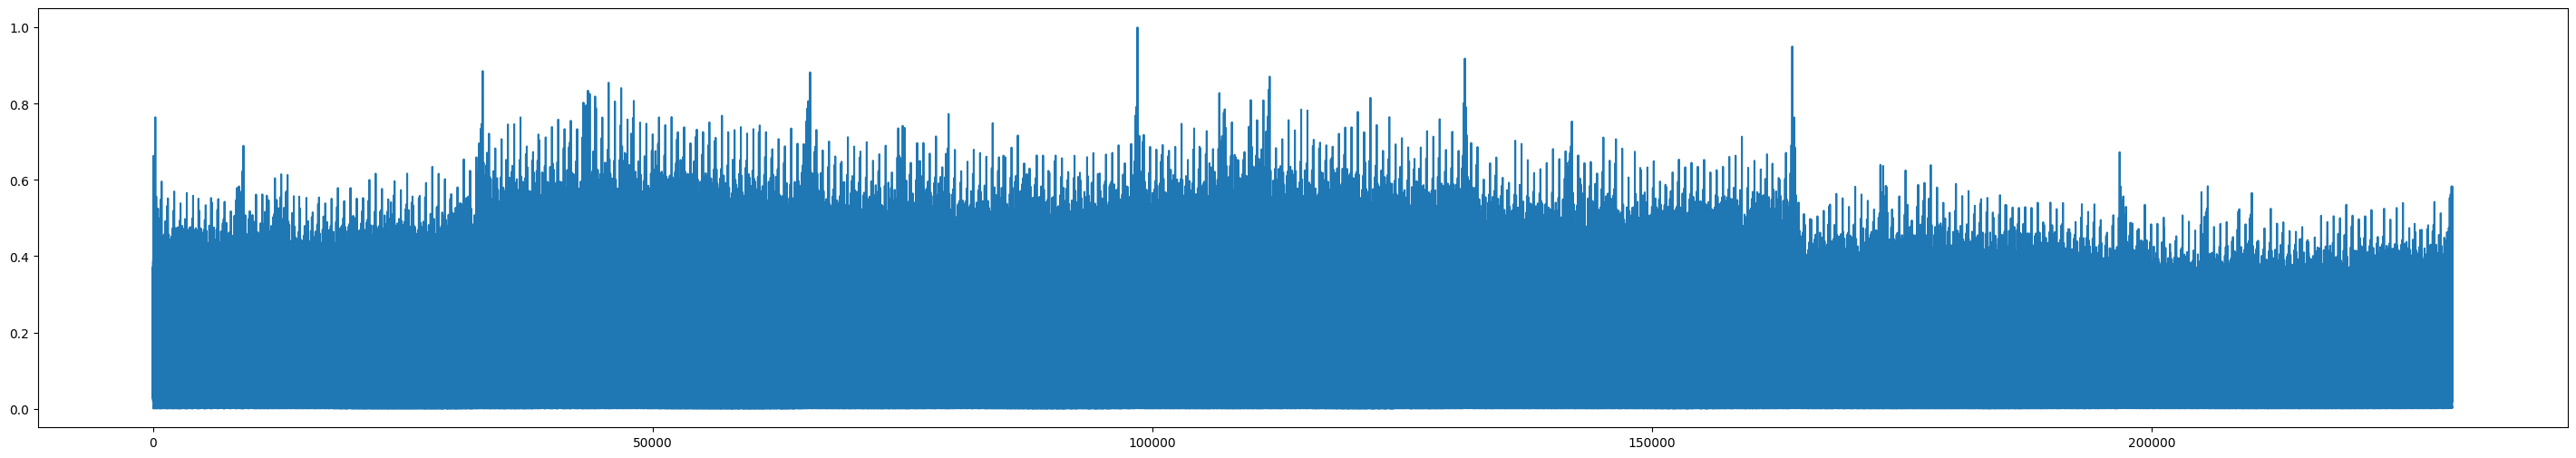

In [44]:
plt.figure(figsize=(36, 6))
plt.plot(df['num_sold_scaled'])

In [46]:
df.glimpse(max_items_per_column=2)

Rows: 328680
Columns: 22
$ id                         <u32> 0, 1
$ country_Canada              <u8> 1, 1
$ country_Finland             <u8> 0, 0
$ country_Italy               <u8> 0, 0
$ country_Kenya               <u8> 0, 0
$ country_Norway              <u8> 0, 0
$ country_Singapore           <u8> 0, 0
$ store_Discount Stickers     <u8> 1, 1
$ store_Premium Sticker Mart  <u8> 0, 0
$ store_Stickers for Less     <u8> 0, 0
$ product_Holographic Goose   <u8> 1, 0
$ product_Kaggle              <u8> 0, 1
$ product_Kaggle Tiers        <u8> 0, 0
$ product_Kerneler            <u8> 0, 0
$ product_Kerneler Dark Mode  <u8> 0, 0
$ year                       <f64> 0.1, 0.1
$ month_sin                  <f64> 0.49999999999999994, 0.49999999999999994
$ day_sin                    <f64> 0.20129852008866006, 0.20129852008866006
$ weekday_sin                <f64> -0.9749279121818236, -0.9749279121818236
$ ordinal_day_sin            <f64> 0.01716632975470737, 0.01716632975470737
$ week_sin                 

In [48]:
df.write_parquet('exported_df.parquet')

In [49]:
df

id,country_Canada,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode,year,month_sin,day_sin,weekday_sin,ordinal_day_sin,week_sin,num_sold_scaled
u32,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,f64,f64,f64,f64,f64,f64,f64
0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0.1,0.5,0.201299,-0.974928,0.017166,-2.4493e-16,null
1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0.1,0.5,0.201299,-0.974928,0.017166,-2.4493e-16,0.163832
2,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0.1,0.5,0.201299,-0.974928,0.017166,-2.4493e-16,0.152551
3,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0.1,0.5,0.201299,-0.974928,0.017166,-2.4493e-16,0.071224
4,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0.1,0.5,0.201299,-0.974928,0.017166,-2.4493e-16,0.082674
5,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0.1,0.5,0.201299,-0.974928,0.017166,-2.4493e-16,0.050514
6,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0.1,0.5,0.201299,-0.974928,0.017166,-2.4493e-16,0.309311
7,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0.1,0.5,0.201299,-0.974928,0.017166,-2.4493e-16,0.27934
8,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0.1,0.5,0.201299,-0.974928,0.017166,-2.4493e-16,0.135881


In [50]:
df_train = df[:train_last_row_idx + 1]
df_test = df[train_last_row_idx + 1:]
print(df_train[-1], df_test[0])

shape: (1, 22)
┌────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ id     ┆ country_Ca ┆ country_Fi ┆ country_I ┆ … ┆ weekday_s ┆ ordinal_d ┆ week_sin  ┆ num_sold_ │
│ ---    ┆ nada       ┆ nland      ┆ taly      ┆   ┆ in        ┆ ay_sin    ┆ ---       ┆ scaled    │
│ u32    ┆ ---        ┆ ---        ┆ ---       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ ---       │
│        ┆ u8         ┆ u8         ┆ u8        ┆   ┆ f64       ┆ f64       ┆           ┆ f64       │
╞════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 230129 ┆ 0          ┆ 0          ┆ 0         ┆ … ┆ -0.781831 ┆ -2.4493e- ┆ -0.118273 ┆ 0.27311   │
│        ┆            ┆            ┆           ┆   ┆           ┆ 16        ┆           ┆           │
└────────┴────────────┴────────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘ shape: (1, 22)
┌────────┬────────────┬────────────┬───────────┬───┬─────────

In [51]:
df_train.write_parquet('train_preprocessed.parquet')
df_test.write_parquet('test_preprocessed.parquet')

In [52]:
sample_submission_df.write_parquet('sample_submission.parquet')